In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from glob import glob
from tqdm.notebook import tqdm

plt.style.use("seaborn")

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [2]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_3.csv.gz")
df.head()

/tmp/ipykernel_32453/2945424485.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{BASE}work_data/matriz_desercion_3.csv.gz")


,cat_periodo,codigo_unico,mrun,gen_alu,fec_nac_alu,anio_ing_carr_ori,tipo_inst_1,region_sede,valor_arancel,area_conocimiento,acreditada_carr,acreditada_inst,desertor_1,region_colegio,tipo_ensenanza_colegio,prom_notas_media,dependencia_colegio,fscu,gratuidad,beca
0,2015,I498S6C132J2V1,37.0,1,197808,2015,Centros de Formación Técnica,Biobío,820000.0,Tecnología,NO ACREDITADA,ACREDITADA,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2015,I111S14C309J2V1,118.0,1,199102,2015,Institutos Profesionales,Metropolitana,1390000.0,Administración y Comercio,ACREDITADA,ACREDITADA,0.0,13,310.0,4.975,3.0,0.0,0.0,0.0
2,2015,I106S3C64J4V1,253.0,1,198404,2015,Institutos Profesionales,Metropolitana,920000.0,Administración y Comercio,NO ACREDITADA,NO ACREDITADA,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,2015,I221S1C57J1V1,370.0,2,198910,2015,Centros de Formación Técnica,Metropolitana,1880000.0,Administración y Comercio,ACREDITADA,ACREDITADA,1.0,13,310.0,5.100,3.0,0.0,0.0,1.0
4,2015,I176S8C59J2V1,533.0,2,198309,2015,Institutos Profesionales,Coquimbo,1190000.0,Salud,ACREDITADA,NO ACREDITADA,0.0,4,510.0,5.200,2.0,0.0,0.0,0.0


In [3]:
def iter_df_read(file, col_name, condition_list, chunksize=1000, **kwargs):
    iter_csv = pd.read_csv(file, iterator=True, chunksize=chunksize, **kwargs)
    return pd.concat([chunk[chunk[col_name].isin(condition_list)] for chunk in iter_csv])

In [4]:
cols = ['tipo_inst_1', 'codigo_unico', 'nomb_inst']
tipo_inst = ['Institutos Profesionales', 'Centros de Formación Técnica']

instituciones = pd.concat([
    iter_df_read(f, "tipo_inst_1", tipo_inst, sep=";", usecols=cols)
    for f in tqdm(glob(f"{BASE}/raw_data/post_2015/20220719_Matrícula_Ed_Superior_*.csv"), total=8)
]).drop_duplicates().reset_index(drop=True)
print(instituciones.shape)
instituciones.head()

  0%|          | 0/8 [00:00<?, ?it/s]

(13055, 3)


,codigo_unico,tipo_inst_1,nomb_inst
0,I374S1C9J1V1,Centros de Formación Técnica,CFT ICEL
1,I498S6C132J2V1,Centros de Formación Técnica,CFT PROANDES
2,I111S12C104J1V1,Institutos Profesionales,IP DUOC UC
3,I111S14C309J2V1,Institutos Profesionales,IP DUOC UC
4,I260S44C120J2V1,Centros de Formación Técnica,CFT SANTO TOMAS


In [5]:
merge = pd.merge(
    df,
    instituciones,
    how="left"
)

merge.shape, df.shape

((2746514, 21), (2746514, 20))

# Deserción por año instituciones más frecuentes

In [6]:
frecuentes = merge["nomb_inst"].value_counts().head(15).index

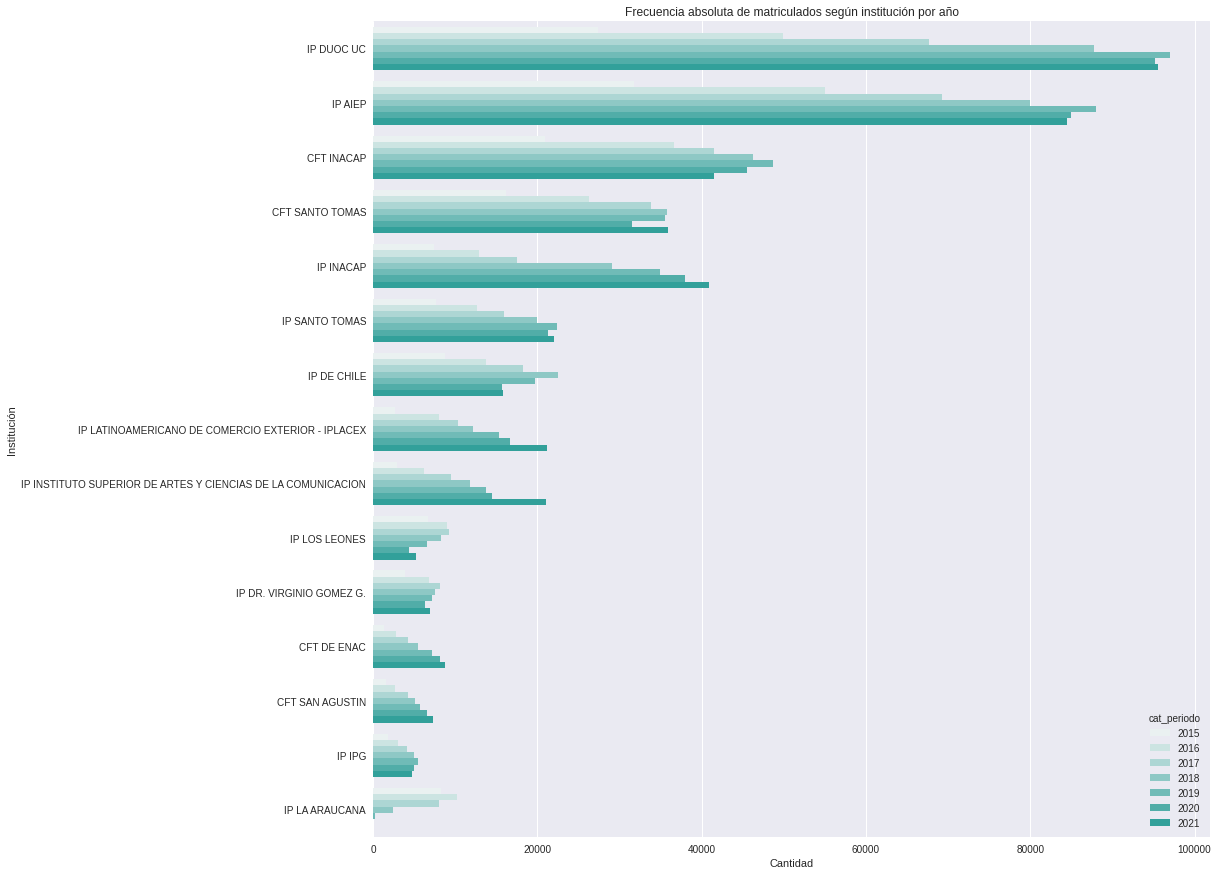

In [78]:
plt.figure(figsize=(15, 15))
sns.countplot(
    data=merge,
    y="nomb_inst",
    order=frecuentes,
    color="lightseagreen",
    hue="cat_periodo"
)
plt.ylabel("Institución")
plt.xlabel("Cantidad")
plt.title("Frecuencia absoluta de matriculados según institución por año");

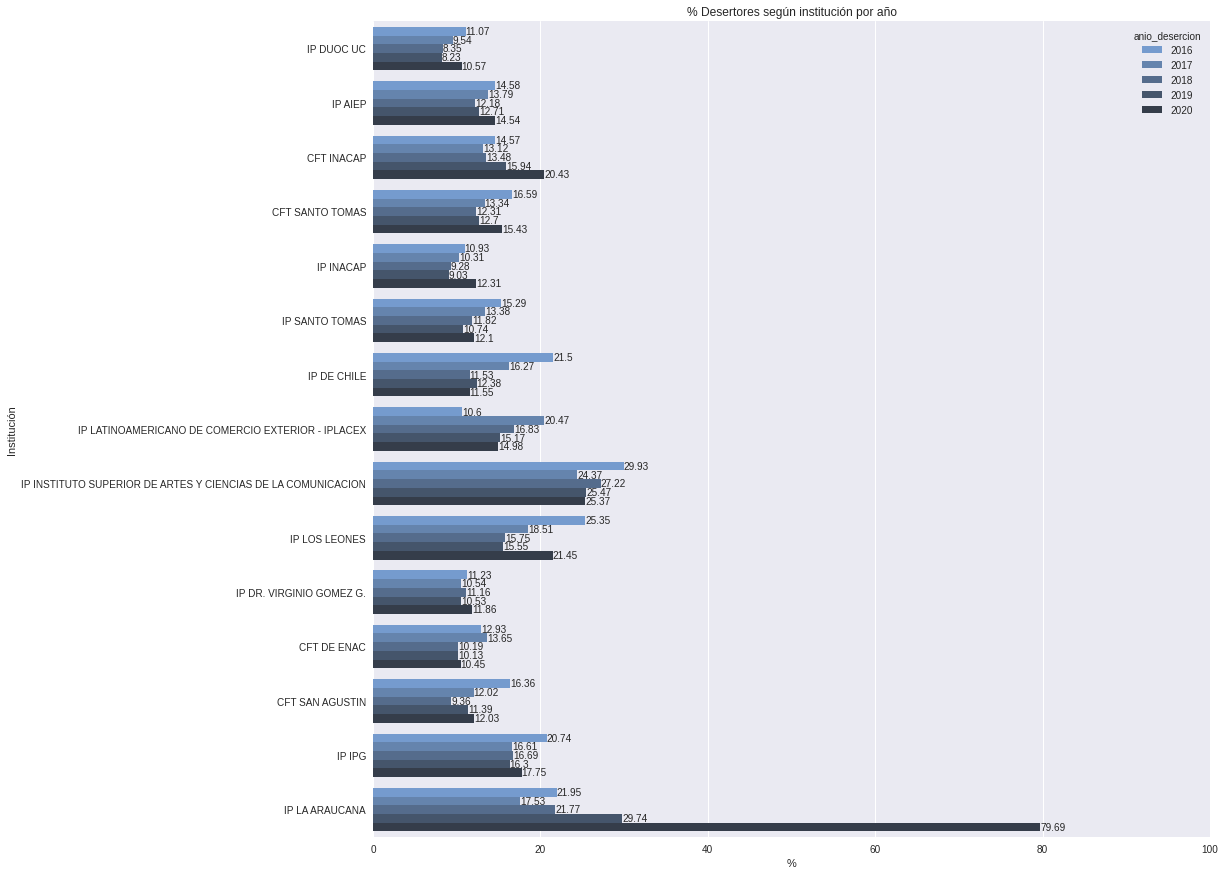

In [79]:
tmp_time = merge[merge["nomb_inst"].isin(frecuentes)].groupby([ # [merge["nomb_inst"].isin(frecuentes)]
    "cat_periodo", "nomb_inst"
])["desertor_1"].value_counts("%").mul(100).rename('%').round(2).reset_index()

plot_time = tmp_time[
    (tmp_time["desertor_1"]==1)
    & (tmp_time["cat_periodo"]<2020)
].copy()
plot_time["anio_desercion"] = plot_time["cat_periodo"] + 1

plt.figure(figsize=(15, 15))
ax = sns.barplot(
    data=plot_time,
    y="nomb_inst",
    x="%",
    order=frecuentes,
    #color="seagreen",
    palette=sns.dark_palette("#69d", reverse=True),
    hue="anio_desercion"
)
plt.ylabel("Institución")
plt.xlabel("%")
plt.xlim([0, 100])
plt.title("% Desertores según institución por año");

for container in ax.containers:
    ax.bar_label(container)

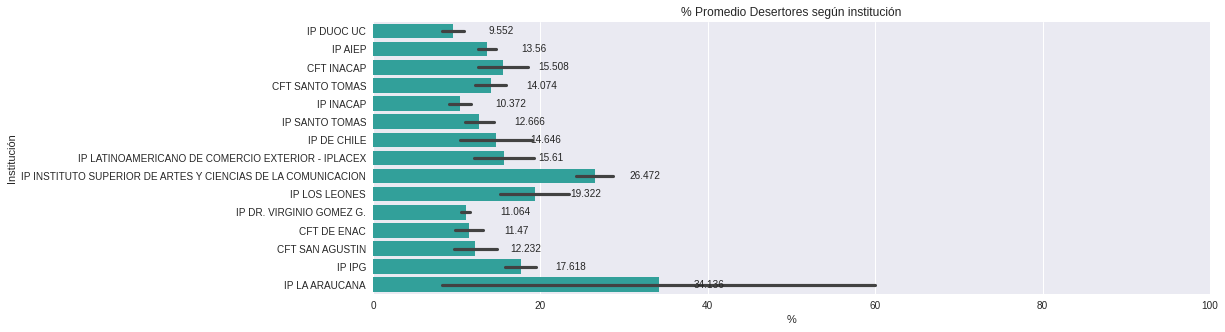

In [81]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(
    data=plot_time,
    y="nomb_inst",
    x="%",
    order=frecuentes,
    errorbar=("sd", True),
    color="lightseagreen"
)
plt.ylabel("Institución")
plt.xlabel("%")
plt.xlim([0, 100])
plt.title("% Promedio Desertores según institución");

for container in ax.containers:
    ax.bar_label(container, padding=35)

In [23]:
frecuentes_2 = [
    'IP DUOC UC', 'IP AIEP', 'CFT INACAP', 'CFT SANTO TOMAS', 'IP INACAP', 'IP SANTO TOMAS', 'IP DE CHILE',
    'IP LATINOAMERICANO DE COMERCIO EXTERIOR - IPLACEX', 'IP INSTITUTO SUPERIOR DE ARTES Y CIENCIAS DE LA COMUNICACION',
    'IP LOS LEONES', 'IP DR. VIRGINIO GOMEZ G.', 'CFT DE ENAC', 'CFT SAN AGUSTIN', 'IP IPG'
]

In [24]:
merge["anio_desercion"] = merge["cat_periodo"] + 1

cantidades = merge[
    (merge["anio_desercion"] < 2021)
    & (merge["nomb_inst"].isin(frecuentes_2))
][
    ["anio_desercion", "mrun", "desertor_1", "nomb_inst"]
].drop_duplicates().groupby([
    "anio_desercion", "nomb_inst"
]).agg({
    "mrun": pd.Series.nunique,
    "desertor_1": "sum"
}).reset_index()

cantidades["desertor_1_porc"] = [
    (d / cantidades[
        (cantidades["anio_desercion"] == a)
        & (cantidades["nomb_inst"] == r)
    ]["mrun"].sum()) * 100 
    for a, d, r in zip(cantidades["anio_desercion"], cantidades["desertor_1"], cantidades["nomb_inst"])
]

cantidades.head()

,anio_desercion,nomb_inst,mrun,desertor_1,desertor_1_porc
0,2016,CFT DE ENAC,1353,175.0,12.934220
1,2016,CFT INACAP,20989,3058.0,14.569536
2,2016,CFT SAN AGUSTIN,1632,267.0,16.360294
3,2016,CFT SANTO TOMAS,16125,2675.0,16.589147
4,2016,IP AIEP,31753,4630.0,14.581299


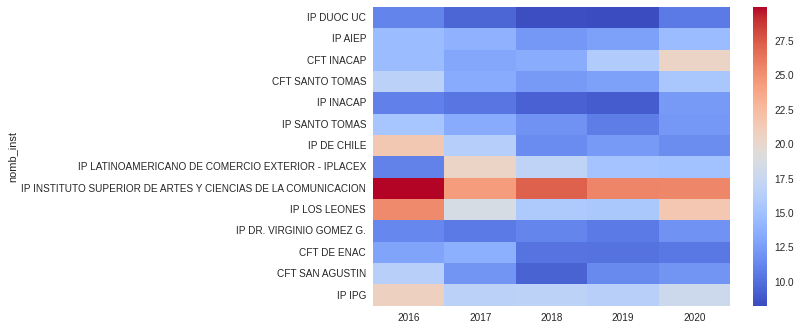

In [25]:
t = cantidades[["anio_desercion", "nomb_inst", "desertor_1_porc"]]
piv = pd.pivot_table(
    t, values="desertor_1_porc", index=["anio_desercion"], columns=["nomb_inst"]
).reset_index().T
piv = piv.rename(columns=piv.iloc[0].astype(int))[1:].reindex(index=frecuentes_2)

#plt.figure(figsize=(5,30))
sns.heatmap(piv, cmap="coolwarm");

In [26]:
melted = pd.melt(piv.dropna().T, value_vars=piv.dropna().index)
model = smf.ols('value ~ C(nomb_inst)', data=melted).fit()
resumen = model.summary2()
resumen.tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.738
1,Dependent Variable:,value,AIC:,337.2195
2,Date:,2022-11-16 09:38,BIC:,368.6985
3,No. Observations:,70,Log-Likelihood:,-154.61
4,Df Model:,13,F-statistic:,15.98
5,Df Residuals:,56,Prob (F-statistic):,2.34e-14
6,R-squared:,0.788,Scale:,6.0659


In [27]:
coefs = resumen.tables[1]
coefs[coefs["P>|t|"] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,11.470938,1.101448,10.414420,1.028210e-14,9.264473,13.677402
C(nomb_inst)[T.CFT INACAP],4.037083,1.557682,2.591724,1.215644e-02,0.916671,7.157495
C(nomb_inst)[T.IP DE CHILE],3.176331,1.557682,2.039140,4.616617e-02,0.055919,6.296743
C(nomb_inst)[T.IP INSTITUTO SUPERIOR DE ARTES Y CIENCIAS DE LA COMUNICACION],15.052144,1.557682,9.663168,1.559122e-13,11.931732,18.172556
C(nomb_inst)[T.IP IPG],6.134005,1.557682,3.937905,2.298614e-04,3.013593,9.254417
C(nomb_inst)[T.IP LATINOAMERICANO DE COMERCIO EXTERIOR - IPLACEX],4.206353,1.557682,2.700392,9.143366e-03,1.085941,7.326765
C(nomb_inst)[T.IP LOS LEONES],7.869559,1.557682,5.052096,4.968799e-06,4.749146,10.989971


# Varianza deserción por institución

In [57]:
cantidades_tot = merge[
    (merge["anio_desercion"] < 2021)
][
    ["anio_desercion", "mrun", "desertor_1", "nomb_inst"]
].drop_duplicates().groupby([
    "anio_desercion", "nomb_inst"
]).agg({
    "mrun": pd.Series.nunique,
    "desertor_1": "sum"
}).reset_index()

cantidades_tot["desertor_1_porc"] = [
    (d / cantidades_tot[
        (cantidades_tot["anio_desercion"] == a)
        & (cantidades_tot["nomb_inst"] == r)
    ]["mrun"].sum()) * 100 
    for a, d, r in zip(cantidades_tot["anio_desercion"], cantidades_tot["desertor_1"], cantidades_tot["nomb_inst"])
]

df_var = cantidades_tot.groupby(["nomb_inst"]).agg({
    "desertor_1_porc": "std",
    "mrun": "sum"
}).reset_index().sort_values(by=["desertor_1_porc"], ascending=False).dropna()
df_var.head()

,nomb_inst,desertor_1_porc,mrun
78,IP HOGAR CATEQUISTICO,70.710678,2
73,IP ESCUELA DE CINE DE CHILE,38.517114,269
58,IP CHILENO NORTEAMERICANO,34.276727,250
27,CFT FINNING,32.278823,256
63,IP DE CIENCIAS DE LA COMPUTACION ACUARIO DATA,32.184557,124


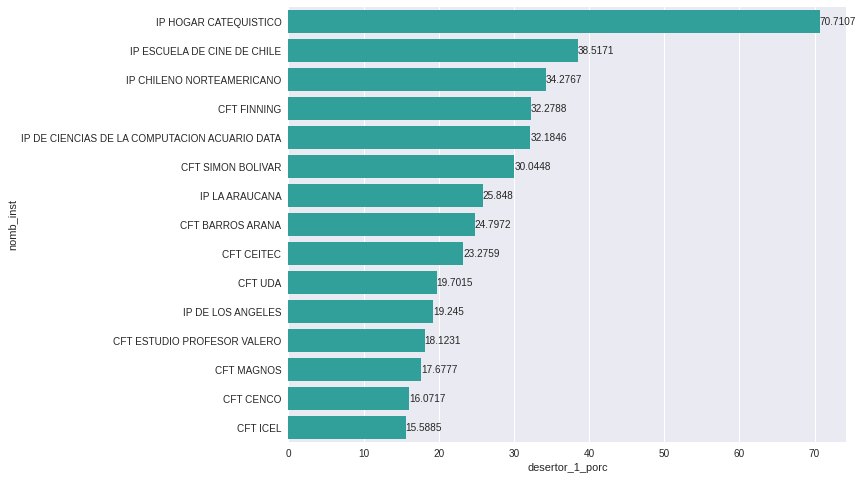

In [59]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(y=df_var["nomb_inst"].head(15), x=df_var["desertor_1_porc"].head(15), color="lightseagreen");

ax.bar_label(ax.containers[0]);

# Diferencia entre CFT/IP

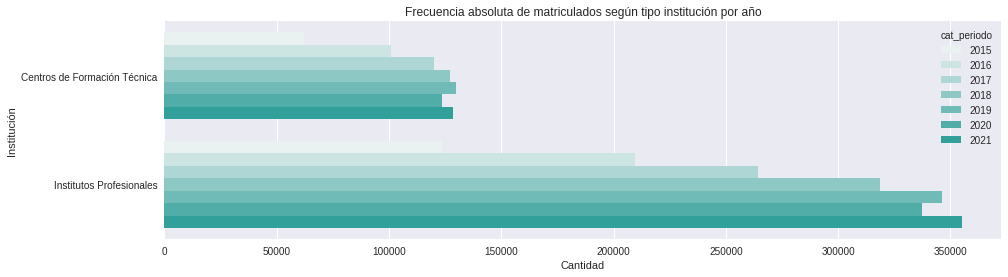

In [82]:
plt.figure(figsize=(15, 4))
sns.countplot(
    data=merge,
    y="tipo_inst_1",
    color="lightseagreen",
    hue="cat_periodo"
)
plt.ylabel("Institución")
plt.xlabel("Cantidad")
plt.title("Frecuencia absoluta de matriculados según tipo institución por año");

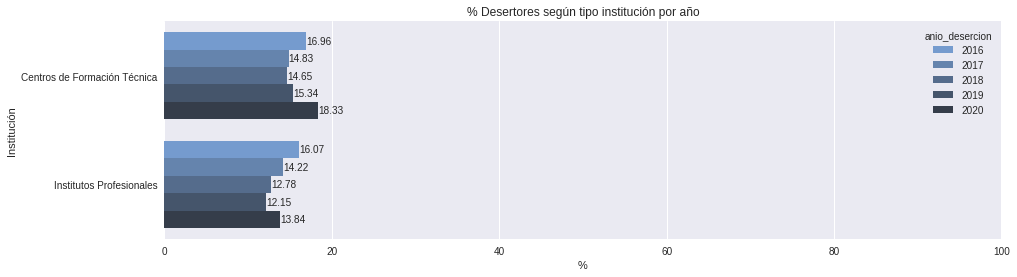

In [83]:
tmp_time = merge.groupby([
    "cat_periodo", "tipo_inst_1"
])["desertor_1"].value_counts("%").mul(100).round(2).rename('%').reset_index()

plot_time = tmp_time[
    (tmp_time["desertor_1"]==1)
    & (tmp_time["cat_periodo"]<2020)
].copy()
plot_time["anio_desercion"] = plot_time["cat_periodo"] + 1

plt.figure(figsize=(15, 4))
ax = sns.barplot(
    data=plot_time,
    y="tipo_inst_1",
    x="%",
    palette=sns.dark_palette("#69d", reverse=True),
    hue="anio_desercion"
)
plt.ylabel("Institución")
plt.xlabel("%")
plt.xlim([0, 100])
plt.title("% Desertores según tipo institución por año");

for container in ax.containers:
    ax.bar_label(container)

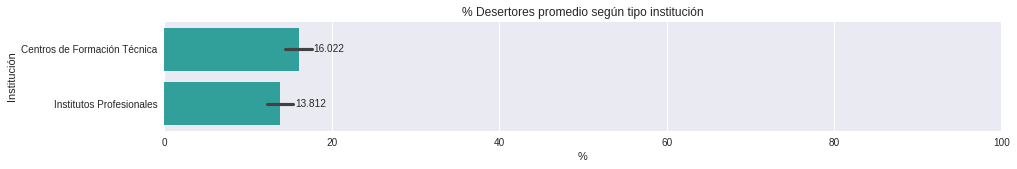

In [84]:
plt.figure(figsize=(15, 2))
ax = sns.barplot(
    data=plot_time,
    y="tipo_inst_1",
    x="%",
    color="lightseagreen",
    errorbar=("sd", True)
)
plt.ylabel("Institución")
plt.xlabel("%")
plt.xlim([0, 100])
plt.title("% Desertores promedio según tipo institución");

for container in ax.containers:
    ax.bar_label(container, padding=15)

# Instituciones con mayor deserción

Considerando desertores únicos en ventana de periodo

## CFT

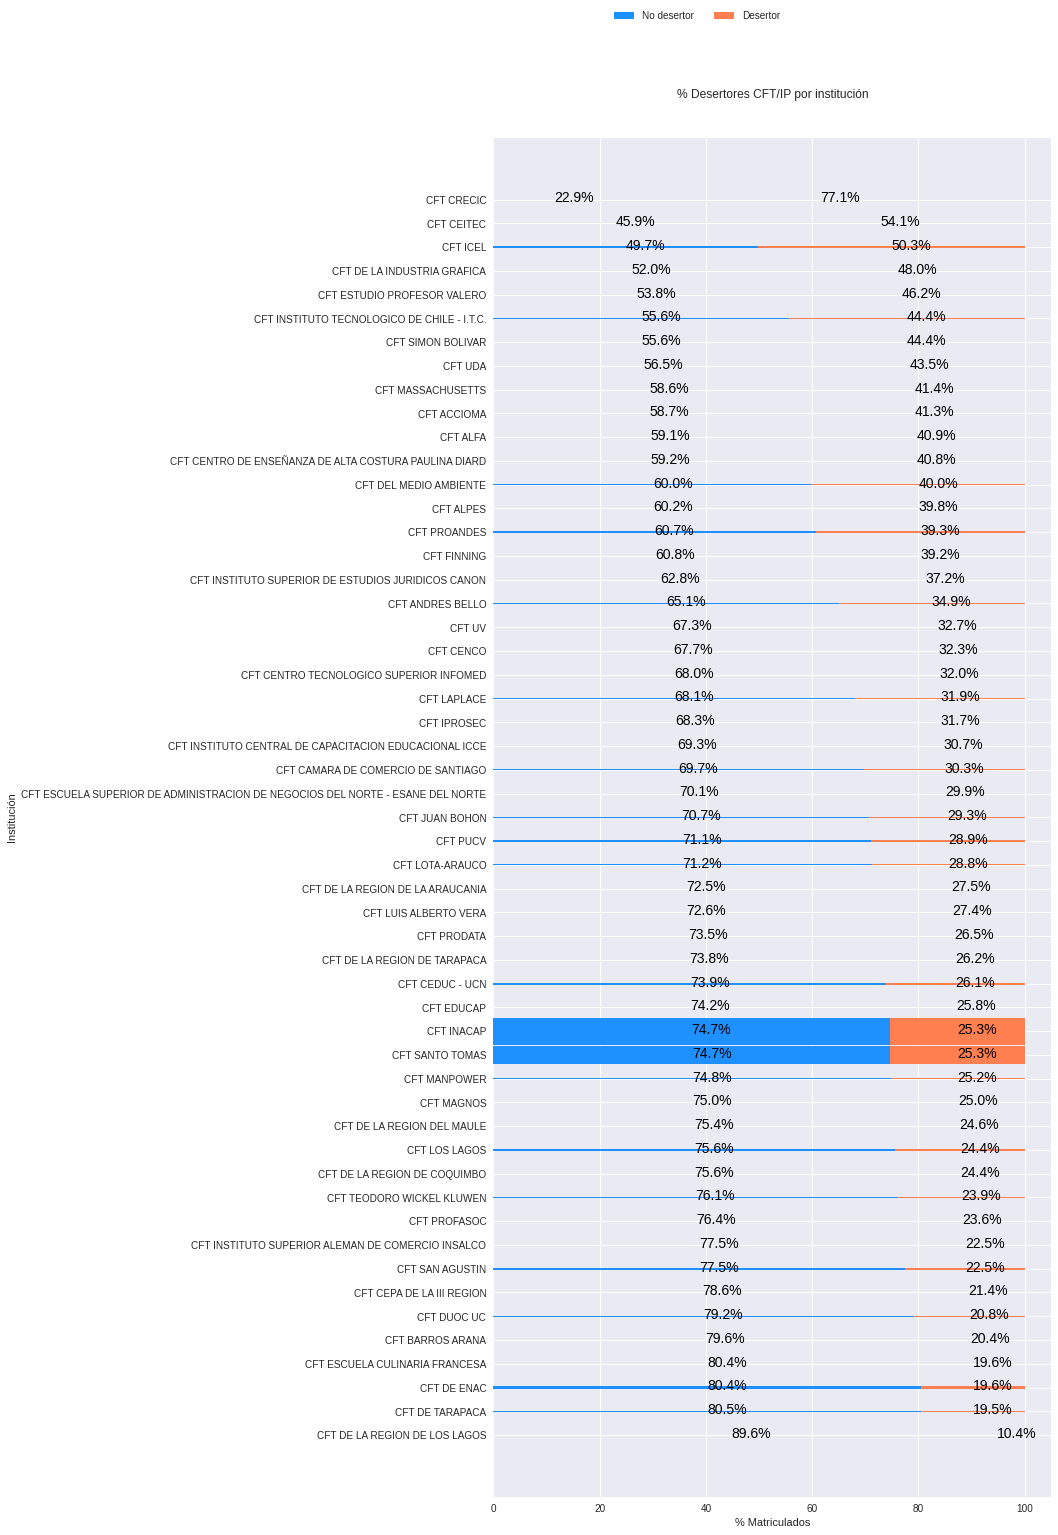

In [125]:
cft = t[t["tipo_inst_1"]=="Centros de Formación Técnica"]

cross_tab_prop = pd.crosstab(index=cft['nomb_inst'],
                             columns=cft['desertor_1'],
                             normalize="index").sort_values(by=[1.0])

cross_tab = pd.crosstab(index=cft['nomb_inst'],
                        columns=cft['desertor_1']).reindex(index = cross_tab_prop.index)

w = np.array(cross_tab.T.sum()/cross_tab.T.sum().sum()) * 3

f, ax = plt.subplots(figsize=(10,25))
plt.rcParams.update({'font.size': 15})

plt.title("% Desertores CFT/IP por institución", pad=40)

b1 = plt.barh(cross_tab_prop.reset_index()['nomb_inst'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['nomb_inst'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)
                
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=14)
        
plt.xticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))

ax.legend(['No desertor', 'Desertor'], loc ='upper left', ncol=2, bbox_to_anchor=(0.2,1.1));
plt.xlabel("% Matriculados");
plt.ylabel("Institución");

## IP

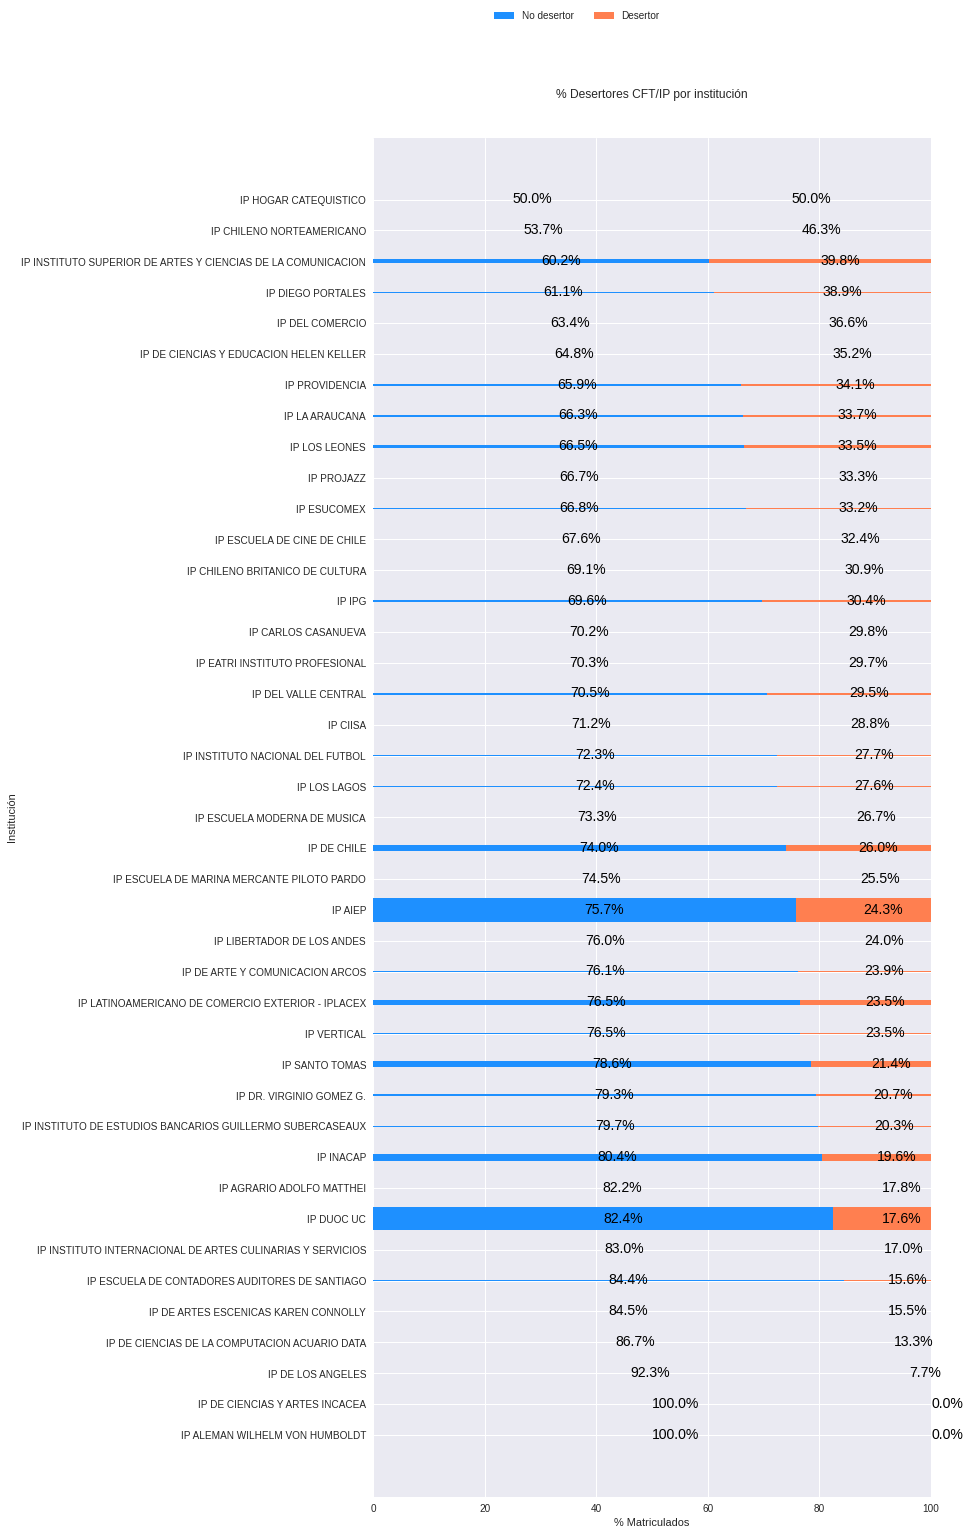

In [124]:
ip = t[t["tipo_inst_1"]=="Institutos Profesionales"]

cross_tab_prop = pd.crosstab(index=ip['nomb_inst'],
                             columns=ip['desertor_1'],
                             normalize="index").sort_values(by=[1.0])

cross_tab = pd.crosstab(index=ip['nomb_inst'],
                        columns=ip['desertor_1']).reindex(index = cross_tab_prop.index)

w = np.array(cross_tab.T.sum()/cross_tab.T.sum().sum()) * 3

f, ax = plt.subplots(figsize=(10,25))
plt.rcParams.update({'font.size': 15})

plt.title("% Desertores CFT/IP por institución", pad=40)

b1 = plt.barh(cross_tab_prop.reset_index()['nomb_inst'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['nomb_inst'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)
                
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=14)
        
plt.xticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))

ax.legend(['No desertor', 'Desertor'], loc ='upper left', ncol=2, bbox_to_anchor=(0.2,1.1));
plt.xlabel("% Matriculados");
plt.ylabel("Institución");